## Problem Statement

At some point or the other almost each one of us has used an Ola or Uber for taking a ride. 

Ride hailing services are services that use online-enabled platforms to connect between passengers and local drivers using their personal vehicles. In most cases they are a comfortable method for door-to-door transport. Usually they are cheaper than using licensed taxicabs. Examples of ride hailing services include Uber and Lyft.

To improve the efficiency of taxi dispatching systems for such services, it is important to be able to predict how long a driver will have his taxi occupied. If a dispatcher knew approximately when a taxi driver would be ending their current ride, they would be better able to identify which driver to assign to each pickup request.

In this project, we are challenged to build a model that predicts the total ride duration of taxi trips in New York City.

## NYC Taxi Trip - ETL (Extract,Transform,Load)

In [75]:
base_URL = 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_'
start_month = '2016/01/01'
end_month = '2016/06/30'
local_path = 'C:/Users/vignesh/delta/nyc-taxi-yellow'
delta_silver_path = 'C:/Users/vignesh/delta/nyc-taxi-yellow/silver'
delta_gold_path = 'C:/Users/vignesh/delta/nyc-taxi-yellow/gold'

In [ ]:
from datetime import datetime
from dateutil.relativedelta import *
import time
import urllib.request
    
def to_date(string_date):
    return datetime.strptime(string_date, '%Y/%m/%d')

iter_month = start_month
checkpoint = ''
total_rows = 0 
file_count = 0

while to_date(iter_month) <= to_date(end_month):
    file_name = to_date(iter_month).strftime('%Y-%m') + '.csv'
    file_path = base_URL + file_name
  
    try:
        ts = time.time()

    # Get data
        print('[INFO] Downloading file {}...'.format(file_name))
        urllib.request.urlretrieve(file_path, local_path+file_name)

        # Get row count
        row_count = spark.read.format('csv').option('header', True).load(local_path+file_name).count()
        total_rows += row_count

        te = time.time()
        elapsed = te-ts

        iter_month = (to_date(iter_month) + relativedelta(months=+1)).strftime('%Y/%m/%d')
        file_count += 1

        print('[INFO] Successfully downloaded {} (Rows copied: {},  elapsed time: {:.2f} min)'.format(file_name, row_count, elapsed/60))

    except Exception as e:
        checkpoint = iter_month
        print ('[ERROR] Checkpoint is {} -> {}'.format(checkpoint, e))
    break


print('Total number of files: {}, Total number of rows: {:.1f} millions'.format(file_count, total_rows/1e6))

Data is already obtained and stored as nyc_taxi_final.zip

## 1. Exploratory Data Analysis
Let's check the data files! According to the data description we should find the following columns:

 - **id** - a unique identifier for each trip
 - **vendor_id** - a code indicating the provider associated with the trip record
 - **pickup_datetime** - date and time when the meter was engaged
 - **dropoff_datetime** - date and time when the meter was disengaged
 - **passenger_count** - the number of passengers in the vehicle (driver entered value)
 - **pickup_longitude** - the longitude where the meter was engaged
 - **pickup_latitude** - the latitude where the meter was engaged
 - **dropoff_longitude** - the longitude where the meter was disengaged
 - **dropoff_latitude** - the latitude where the meter was disengaged
 - **store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)
 - **trip_duration** - (target) duration of the trip in seconds

Here, we have 2 variables dropoff_datetime and store_and_fwd_flag which are not available before the trip starts and hence will not be used as features to the model.

## Load the Libraries

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime as dt

In [77]:
df=pd.read_csv('nyc_taxi_final.zip')

In [78]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848


In [79]:
df.shape

(729322, 11)

In [80]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729322 entries, 0 to 729321
Data columns (total 11 columns):
id                    729322 non-null object
vendor_id             729322 non-null int64
pickup_datetime       729322 non-null object
dropoff_datetime      729322 non-null object
passenger_count       729322 non-null int64
pickup_longitude      729322 non-null float64
pickup_latitude       729322 non-null float64
dropoff_longitude     729322 non-null float64
dropoff_latitude      729322 non-null float64
store_and_fwd_flag    729322 non-null object
trip_duration         729322 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 61.2+ MB


### Missing Values
Knowing about missing values is important because they indicate how much we don’t know about our data. Making inferences based on just a few cases is often unwise. In addition, many modelling procedures break down when missing values are involved and the corresponding rows will either have to be removed completely or the values need to be estimated somehow.

In [82]:
np.sum(df.isnull())

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

### Reformatting features & Checking consistency
There are a variety of features within the dataset and it is important to convert them into the right format such that we can analyse them easily. This would include converting datetime features and string features. 

Also, one important thing is never to take assumptions without backing it with data. Here, as you can see the trip duration can also be calculated pick up and drop off datetime. We will check whether the given duration is consistent with the calculated trip duration 

In [83]:
#Converting strings to datetime objects
df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime']=pd.to_datetime(df['dropoff_datetime'])

In [84]:
#checking consistency
df['check_trip_duration']=(df['dropoff_datetime']-df['pickup_datetime']).dt.seconds

In [85]:
((df['check_trip_duration']-df['trip_duration']).values)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [86]:
sum((df['check_trip_duration']-df['trip_duration']).values)

-1900800

In [87]:
min((df['check_trip_duration']-df['trip_duration']).values)

-1900800

In [20]:
df[(df['check_trip_duration']-df['trip_duration']).values==-1900800]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,check_trip_duration
21813,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.78965,40.643559,-73.95681,40.773087,N,1939736,38936


In [88]:
# Removing inconsistency
df=df[(df['check_trip_duration']-df['trip_duration']).values!=-1900800]

In [89]:
df.loc[:,'pickup_day_of_week']=df['pickup_datetime'].dt.dayofweek
df.loc[:,'pickup_hour']=df['pickup_datetime'].dt.hour
df.loc[:,'pickup_minute']=df['pickup_datetime'].dt.minute
df.loc[:,'pickup_second']=df['pickup_datetime'].dt.second

In [90]:
#Reformatting Y/N flags to 1/0 values
df.loc[:,'store_and_fwd_flag']=[1 if i=="Y" else 0 for i in df['store_and_fwd_flag']]

In [91]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,check_trip_duration,pickup_day_of_week,pickup_hour,pickup_minute,pickup_second
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,0,400,400,0,16,40,21
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,0,1100,1100,4,23,35,37
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,0,1635,1635,6,17,59,33
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,0,1141,1141,1,9,44,31
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,0,848,848,2,6,42,23


## Target Exploration

In [92]:
df['trip_duration'].describe()/3600

count    202.589167
mean       0.263770
std        0.868756
min        0.000278
25%        0.110278
50%        0.184167
75%        0.298611
max       23.997500
Name: trip_duration, dtype: float64

 One idea to visualise the trip duration better is to log transform it before prediction

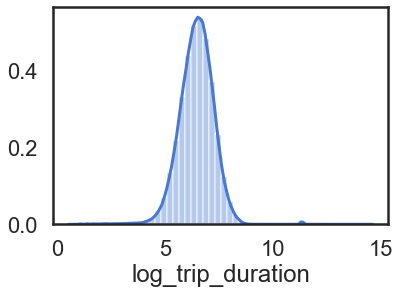

In [72]:
#Normalisation
df.loc[:,'log_trip_duration']=np.log(df['trip_duration']+1)
sns.distplot(df['log_trip_duration'])

We find:

1. The majority of rides follow a rather smooth distribution that looks almost log-normal with a peak just around exp(6.5)  i.e. about 17 minutes.
2. There are several suspiciously short rides with less than 10 seconds duration.

In [93]:
df[df['trip_duration']<60]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,check_trip_duration,pickup_day_of_week,pickup_hour,pickup_minute,pickup_second
136,id1514658,1,2016-03-22 08:23:09,2016-03-22 08:23:16,2,-73.902054,40.764011,-73.902061,40.764023,0,7,7,1,8,23,9
415,id0446273,2,2016-04-04 12:56:16,2016-04-04 12:56:26,5,-73.863091,40.769840,-73.863312,40.769630,0,10,10,0,12,56,16
448,id1326538,2,2016-03-18 12:19:33,2016-03-18 12:19:42,1,-73.974197,40.762718,-73.975693,40.760723,0,9,9,4,12,19,33
785,id1764292,1,2016-03-15 15:13:22,2016-03-15 15:14:16,1,-73.985260,40.763458,-73.982109,40.767265,0,54,54,1,15,13,22
1493,id1359484,1,2016-04-28 09:59:34,2016-04-28 10:00:32,1,-73.996864,40.737514,-73.998665,40.738136,0,58,58,3,9,59,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728793,id0802812,1,2016-05-12 05:52:36,2016-05-12 05:52:42,1,-73.985931,40.767986,-73.985931,40.767982,0,6,6,3,5,52,36
729011,id2277062,2,2016-02-17 05:26:18,2016-02-17 05:26:30,2,-73.978523,40.765221,-73.979462,40.765781,0,12,12,2,5,26,18
729022,id3715420,1,2016-05-29 12:04:06,2016-05-29 12:04:33,1,-73.945587,40.751602,-73.945602,40.751568,0,27,27,6,12,4,6
729073,id1124394,2,2016-03-12 22:38:09,2016-03-12 22:38:58,2,-73.962418,40.758919,-73.960655,40.761398,0,49,49,5,22,38,9


In [94]:
#Removing Inconsistency
df=df[df['trip_duration']>60]

## Univariate Analysis

Text(0, 0.5, 'No. of Trips')

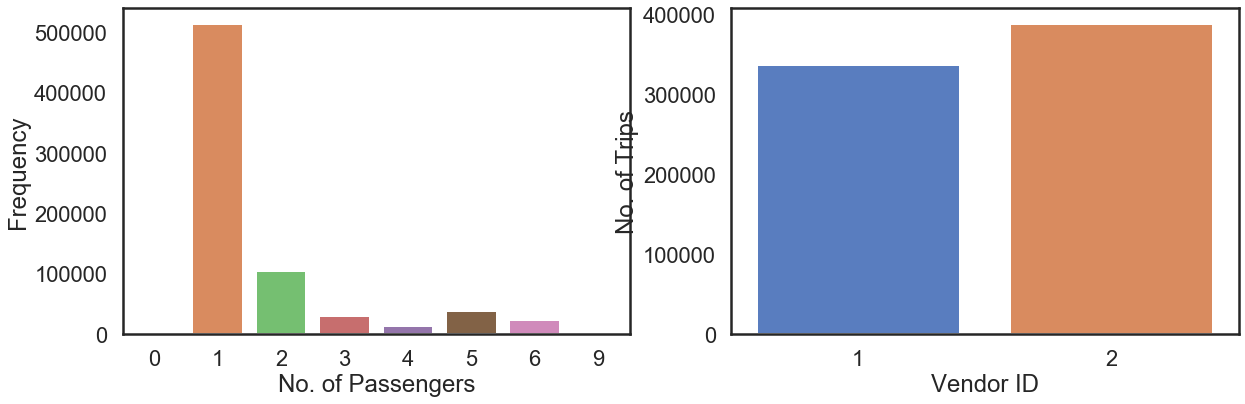

In [95]:
plt.figure(figsize=(20,6))


#Passenger Count
plt.subplot(121)
sns.countplot(df['passenger_count'])
plt.xlabel('No. of Passengers')
plt.ylabel('Frequency')

#Vendor Id
plt.subplot(122)
sns.countplot(df['vendor_id'])
plt.xlabel('Vendor ID')
plt.ylabel('No. of Trips')


Observations:
1. Most of the trips involve only 1 passenger. There are trips with 7-9 passengers but they are very low in number.
2. Vendor 2 has more number of trips as compared to vendor 1

Text(0, 0.5, 'Total number of trips')

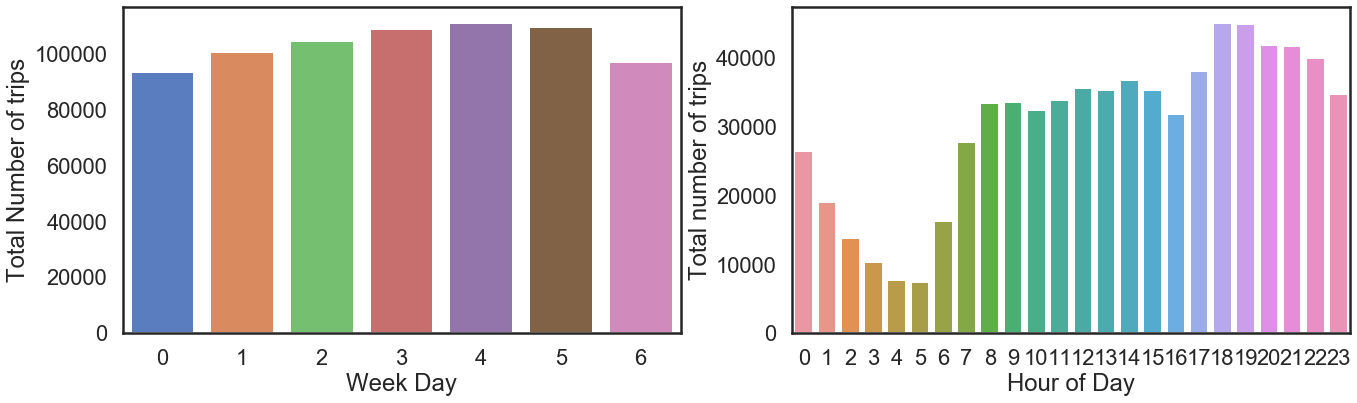

In [96]:

# Datetime features
plt.figure(figsize=(22, 6))

# Passenger Count
plt.subplot(121)
sns.countplot(df['pickup_day_of_week'])
plt.xlabel('Week Day')
plt.ylabel('Total Number of trips')

# vendor_id
plt.subplot(122)
sns.countplot(df['pickup_hour'])
plt.xlabel('Hour of Day')
plt.ylabel('Total number of trips')


* Number of pickups for weekends is much lower than week days with a peak on Thursday (4). Note that here weekday is a decimal number, where 0 is Sunday and 6 is Saturday.
* Number of pickups as expected is highest in late evenings. However, it is much lower during the morning peak hours.

Text(0.5, 0, 'dropoff_longitude')

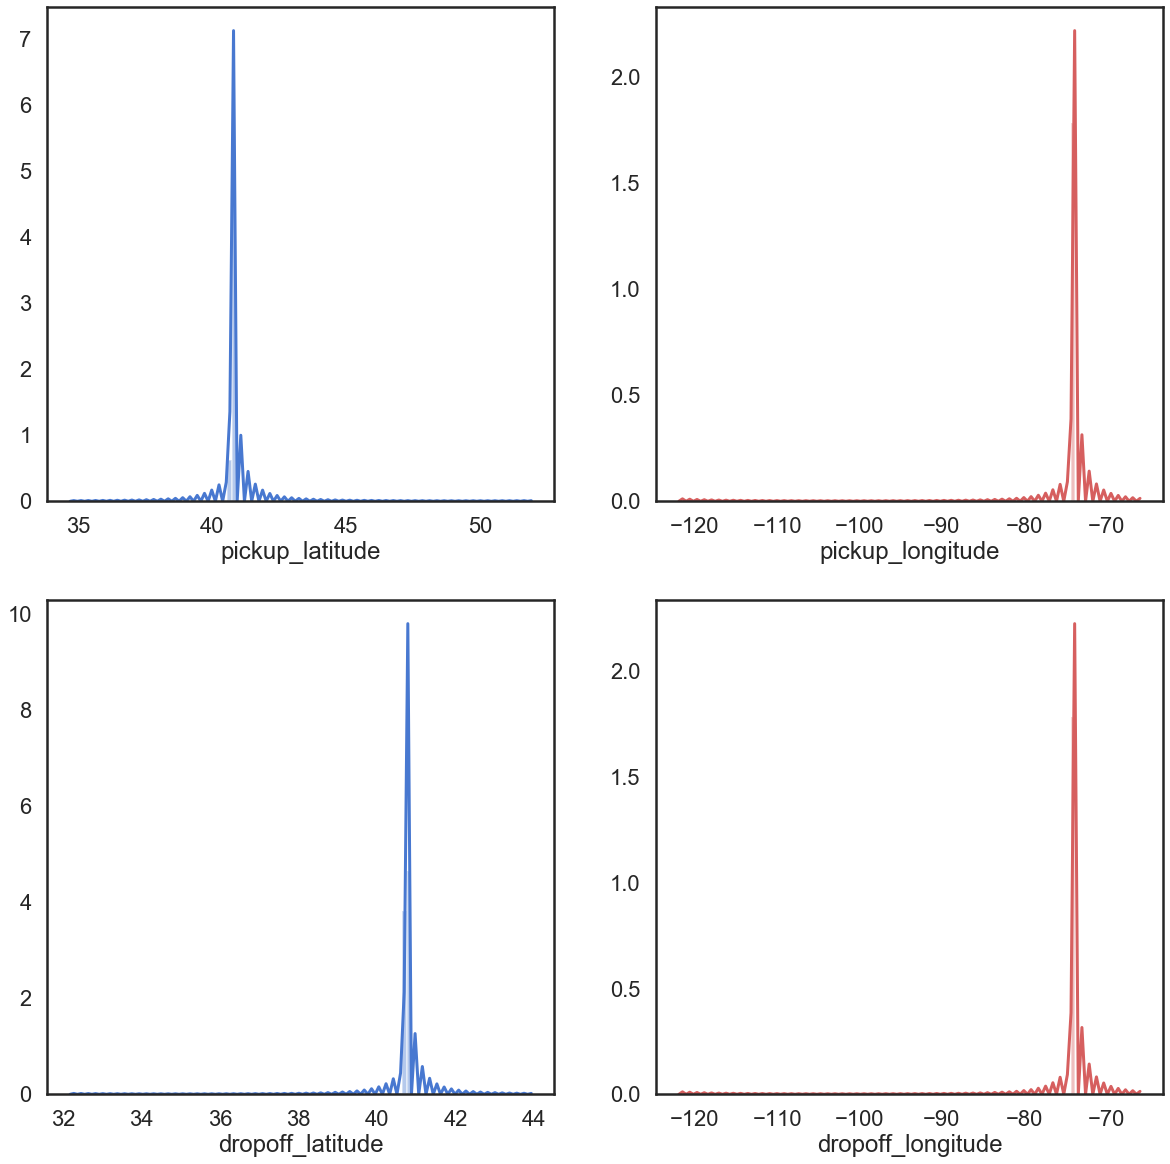

In [97]:
plt.figure(figsize=(20,20))

plt.subplot(221)
sns.distplot(df['pickup_latitude'].values, label = 'pickup_latitude',color="b",bins = 100)
plt.xlabel('pickup_latitude')

plt.subplot(222)
sns.distplot(df['pickup_longitude'].values, label = 'pickup_longitude',color="r",bins =100)
plt.xlabel('pickup_longitude')

plt.subplot(223)
sns.distplot(df['dropoff_latitude'].values, label = 'dropoff_latitude',color="b",bins =100)
plt.xlabel('dropoff_latitude')

plt.subplot(224)
sns.distplot(df['dropoff_longitude'].values, label = 'dropoff_longitude',color="r",bins =100)  
plt.xlabel("dropoff_longitude")

Findings - (Here, red represents pickup and dropoff Longitudes & blue represents pickup & dropoff lattitudes)

1. From the plot above it is clear that pick and drop latitude are centered around 40 to 41, and longitude are situated around -74 to -73. 
2. Some extreme co-ordinates has squeezed the plot such that we see a spike here
3. A good idea is to remove these outliers and look at the distribution more closely

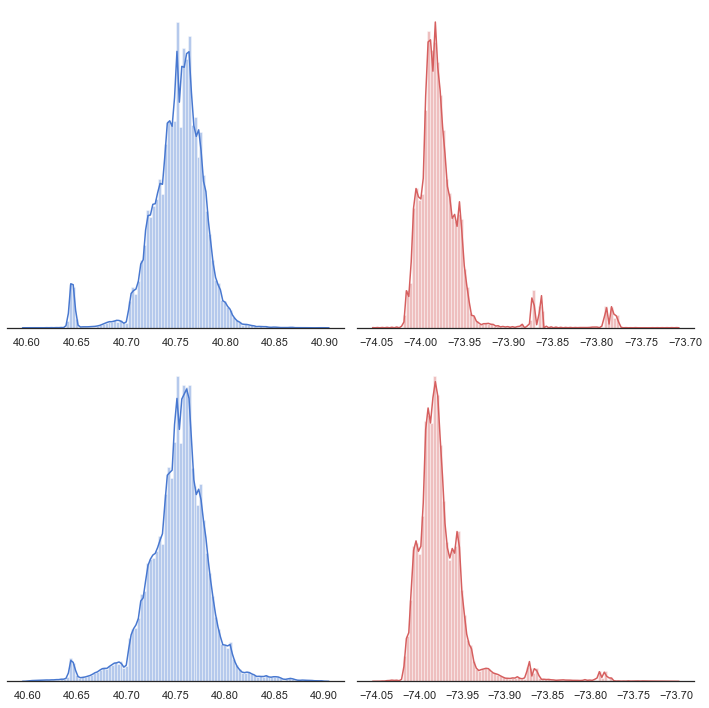

In [32]:
df = df.loc[(df.pickup_latitude > 40.6) & (df.pickup_latitude < 40.9)]
df = df.loc[(df.dropoff_latitude>40.6) & (df.dropoff_latitude < 40.9)]
df = df.loc[(df.dropoff_longitude > -74.05) & (df.dropoff_longitude < -73.7)]
df = df.loc[(df.pickup_longitude > -74.05) & (df.pickup_longitude < -73.7)]
df_data_new = df.copy()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)#
sns.despine(left=True)
sns.distplot(df_data_new['pickup_latitude'].values, label = 'pickup_latitude',color="b",bins = 100, ax=axes[0,0])
sns.distplot(df_data_new['pickup_longitude'].values, label = 'pickup_longitude',color="r",bins =100, ax=axes[0,1])
sns.distplot(df_data_new['dropoff_latitude'].values, label = 'dropoff_latitude',color="b",bins =100, ax=axes[1, 0])
sns.distplot(df_data_new['dropoff_longitude'].values, label = 'dropoff_longitude',color="r",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()

plt.show()

* We have a much better view of the distribution of coordinates instead of spikes. And we see that most trips are concentrated between these lat long only with a few significant clusters.
* These clusters are represented by the numerous peaks in the lattitude and longitude histograms


### Bivariate Relations with Target


### Trip Duration vs Weekday

For different week days, the trip durations can vary as different week days might have different traffic densities especially the weekends might have a much different patterns as compared to working days. Weekday is taken as a decimal number, where 0 - Sunday and 6 is Saturday.

C:\Users\vignesh\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


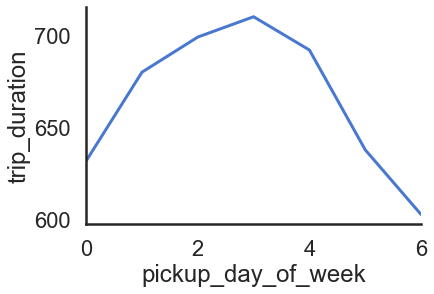

In [33]:
summary= pd.DataFrame(df.groupby(['pickup_day_of_week'])['trip_duration'].median())
summary.reset_index(inplace = True)
summary['unit']=1

sns.set_context("poster")
sns.tsplot(data=summary, time="pickup_day_of_week", unit = "unit", value="trip_duration")
sns.despine(bottom = False)

### Trip Duration vs Hour of the Day

For different hours of the day, the trip durations can vary as different hours might have different traffic densities especially the prime hours might have a much different patterns as compared to other hours of the day.

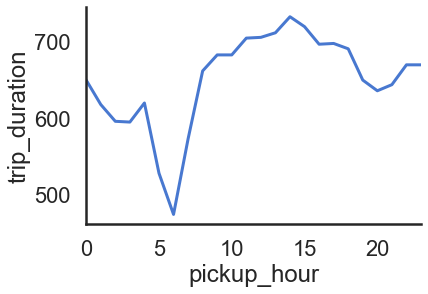

In [34]:
summary = pd.DataFrame(df.groupby(['pickup_hour'])['trip_duration'].median())
summary.reset_index(inplace = True)
summary['unit']=1

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.tsplot(data=summary, time="pickup_hour", unit = "unit", value="trip_duration")
sns.despine(bottom = False)

### Mean Trip Duration Vendor Wise

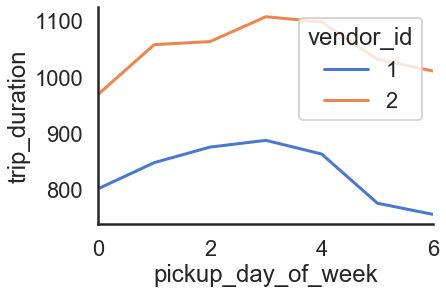

In [35]:
summary = pd.DataFrame(df.groupby(['vendor_id','pickup_day_of_week'])['trip_duration'].mean())
summary.reset_index(inplace = True)
summary['unit']=1

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.tsplot(data=summary, time="pickup_day_of_week", unit = "unit", condition="vendor_id", value="trip_duration")
sns.despine(bottom = False)



### Median Trip Duration Vendor Wise

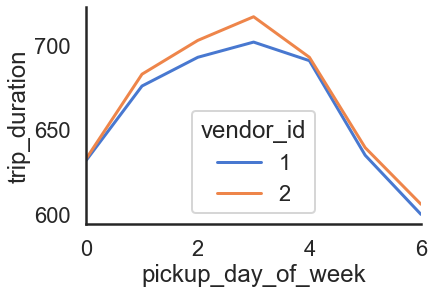

In [36]:
summary = pd.DataFrame(df.groupby(['vendor_id','pickup_day_of_week'])['trip_duration'].median())
summary.reset_index(inplace = True)
summary['unit']=1

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.tsplot(data=summary, time="pickup_day_of_week", unit = "unit", condition="vendor_id", value="trip_duration")
sns.despine(bottom = False)



### Visualise the Pickup points on the lattitude-longitude Map

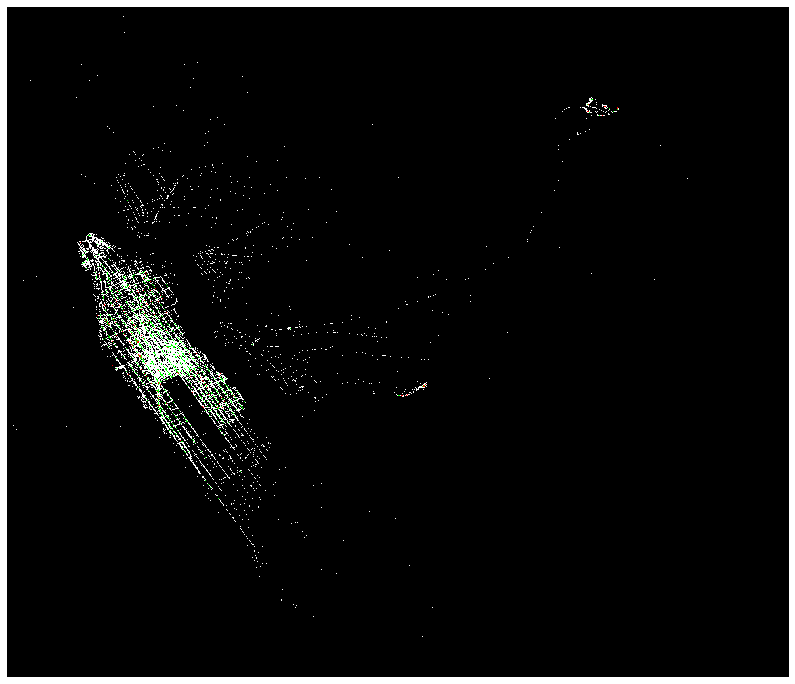

In [37]:
rgb = np.zeros((3000, 3500, 3), dtype=np.uint8)
rgb[..., 0] = 0
rgb[..., 1] = 0
rgb[..., 2] = 0
df_data_new['pick_lat_new'] = list(map(int, (df['pickup_latitude'] - (40.6000))*10000))
df_data_new['drop_lat_new'] = list(map(int, (df['dropoff_latitude'] - (40.6000))*10000))
df_data_new['pick_lon_new'] = list(map(int, (df['pickup_longitude'] - (-74.050))*10000))
df_data_new['drop_lon_new'] = list(map(int,(df['dropoff_longitude'] - (-74.050))*10000))

summary_plot = pd.DataFrame(df_data_new.groupby(['pick_lat_new', 'pick_lon_new'])['id'].count())

summary_plot.reset_index(inplace = True)
summary_plot.head(120)
lat_list = summary_plot['pick_lat_new'].unique()
for i in lat_list:
    lon_list = summary_plot.loc[summary_plot['pick_lat_new']==i]['pick_lon_new'].tolist()
    unit = summary_plot.loc[summary_plot['pick_lat_new']==i]['id'].tolist()
    for j in lon_list:
        a = unit[lon_list.index(j)]
        if (a//25) >0:
            rgb[i][j][0] = 255
            rgb[i,j, 1] = 0
            rgb[i,j, 2] = 0
        elif (a//10)>0:
            rgb[i,j, 0] = 0
            rgb[i,j, 1] = 255
            rgb[i,j, 2] = 0
        else:
            rgb[i,j, 0] = 255
            rgb[i,j, 1] = 255
            rgb[i,j, 2] = 255
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(14,20))
ax.imshow(rgb, cmap = 'hot')
ax.set_axis_off() 

### Correlation Heatmap

In [38]:
plt.figure(figsize=(12, 6))
corr = df.apply(lambda x: pd.factorize(x)[0]).corr()

<Figure size 864x432 with 0 Axes>

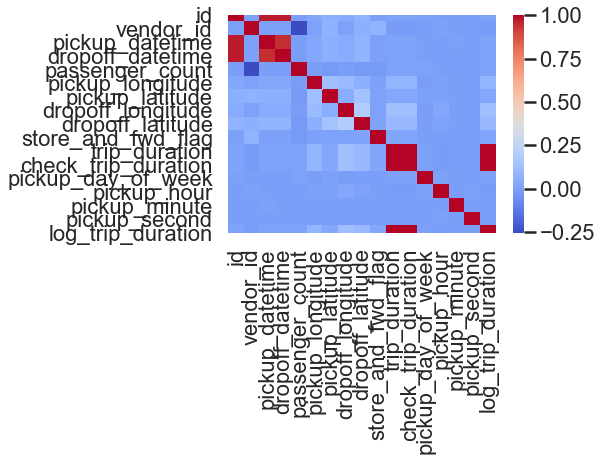

In [39]:
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,cmap="coolwarm")

### Conclusions
1. The majority of rides follow a rather smooth distribution that looks almost log-normal with a peak just around exp(6.5)  i.e. about 17 minutes.
2. There are several suspiciously short rides with less than 10 seconds duration.
3. From the correlation heatmap we see that the lattitude and longitude features have higher correlation with the target as compared to the other features.
4. Most of the trips involve only 1 passenger. There are trips with 7-9 passengers but they are very low in number.
5. Vendor 2 has more number of trips as compared to vendor 1
6. Number of pickups for weekends is much lower than week days with a peak on Thursday (4). Note that here weekday is a decimal number, where 0 is Sunday and 6 is Saturday.
7. Number of pickups as expected is highest in late evenings. However, it is much lower during the morning peak hours.
8. We see that most trips are concentrated between these lat long only with a few significant clusters. These clusters are represented by the numerous peaks in the lattitude and longitude histograms
9. Trip durations are definitely shorter for late night and early morning hours that can be attributed to low traffic density
10. It follows a similar pattern when compared to number of pickups indicating a correlation between number of pickups and trip duration
11. Median trip duration does not vary much as can be seen from the above plot for different vendors.


## NYC Taxi Trip Duration Feature Engineering & Model Building
Now, that we have seen the Exploration and have a good understanding of data shape and structure. We also looked at firstly the basic models such as decision tree and linear regression and later on ensemble methods such as random forest and XGBoost (Gradient Boosting).

But the model is as good as the training data. Can we engineer new features to improve performance? Let's find out

### Distance Features

#### Eucledian Distance
Let's Calculate the Eucledian distance between pickup and drop off location to get some idea on how far the pickup and dropoff points are since this would definitely impact the trip duration

In [40]:
#displacement
y_dist= df['pickup_longitude'] - df['dropoff_longitude']
x_dist = df['pickup_latitude'] - df['dropoff_latitude']

#square distance
df['dist_sq'] = (y_dist ** 2) + (x_dist ** 2)

#distance
df['dist_sqrt'] = df['dist_sq'] ** 0.5

#### Haversine Distance
Let's calculate the distance (km) between pickup and dropoff points. The haversine formula determines the great-circle distance between two points on a sphere given their longitudes and latitudes. We will also calculate the approximate angle at which the dropoff location lies wrt the pickup location. pd.DataFrame.apply() would be too slow so the haversine function is rewritten to handle arrays.


In [41]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def direction_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))


df['haversine_distance'] = haversine_array(df['pickup_latitude'].values, 
                                                     df['pickup_longitude'].values, 
                                                     df['dropoff_latitude'].values, 
                                                     df['dropoff_longitude'].values)


df['direction'] = direction_array(df['pickup_latitude'].values, 
                                          df['pickup_longitude'].values, 
                                          df['dropoff_latitude'].values, 
                                          df['dropoff_longitude'].values)


### Binning
The lattitude and longitude could be a bit noisy and it might be a good idea to bin them and create new features after rounding their values.

In [42]:
### Binned Coordinates ###
df['pickup_latitude_round3'] = np.round(df['pickup_latitude'],3)
df['pickup_longitude_round3'] = np.round(df['pickup_longitude'],3)

df['dropoff_latitude_round3'] = np.round(df['dropoff_latitude'],3)
df['dropoff_longitude_round3'] = np.round(df['dropoff_longitude'],3)

#### One Hot Encoding
Here, Vendor ID can be converted to one hot encoding or frequency encoding since in the raw data it has values 1 and 2 without any inherent order. 

In [43]:
df['vendor_id'] = df['vendor_id'] - 1

In [44]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_second,log_trip_duration,dist_sq,dist_sqrt,haversine_distance,direction,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3
0,id1080784,1,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,0,...,21,5.993961,0.000159,0.012592,1.199073,-135.634530,40.779,-73.954,40.771,-73.964
1,id0889885,0,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,0,...,37,7.003974,0.001397,0.037371,4.129111,-172.445217,40.732,-73.988,40.695,-73.995
2,id0857912,1,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,0,...,33,7.400010,0.005287,0.072712,7.250753,34.916093,40.721,-73.997,40.775,-73.948
3,id3744273,1,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,0,...,31,7.040536,0.000461,0.021473,2.361097,10.043567,40.760,-73.962,40.781,-73.957
4,id0232939,0,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,0,...,23,6.744059,0.001872,0.043264,4.328534,34.280582,40.708,-74.017,40.741,-73.988


Before we go on to build a model, we must drop the variables that should not be fed as features to the algorithms. We will drop
* id - Uniquely represents a sample in the train set
* pickup_datetime - Since we have extracted the datetime features, there is no need to keep the datetime column
* dropoff_datetime - If this is used to create features, it would be a leakage and we will get perfect model performance. Why? The time gap between dropoff_datetime and pickup_datetime is essentially what we are trying to predict
* trip_duration - This is the target variable so needs to be dropped
* store_and_fwd_flag - This variable is not available before the start of the trip and should not be used for modelling.

In [45]:
#Set the Target column
df_y=df['log_trip_duration']

In [46]:
df = df.drop(['id', 'pickup_datetime', 'dropoff_datetime','trip_duration',
              'store_and_fwd_flag','check_trip_duration','log_trip_duration'],axis=1)

In [47]:
df.columns

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'pickup_day_of_week',
       'pickup_hour', 'pickup_minute', 'pickup_second', 'dist_sq', 'dist_sqrt',
       'haversine_distance', 'direction', 'pickup_latitude_round3',
       'pickup_longitude_round3', 'dropoff_latitude_round3',
       'dropoff_longitude_round3'],
      dtype='object')

## Model Building

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from numpy import sqrt
import sklearn
import warnings
warnings.filterwarnings('ignore')

In [49]:
np.sum(df.isnull())

vendor_id                   0
passenger_count             0
pickup_longitude            0
pickup_latitude             0
dropoff_longitude           0
dropoff_latitude            0
pickup_day_of_week          0
pickup_hour                 0
pickup_minute               0
pickup_second               0
dist_sq                     0
dist_sqrt                   0
haversine_distance          0
direction                   0
pickup_latitude_round3      0
pickup_longitude_round3     0
dropoff_latitude_round3     0
dropoff_longitude_round3    0
dtype: int64

### Test Train Split

In [50]:
#Splitting the data into Train and Validation set
from sklearn.model_selection import train_test_split 
xtrain, xtest, ytrain, ytest = train_test_split(df,df_y,test_size=1/3, random_state=0)

### Mean Prediction

In [51]:
mean_pred = np.repeat(ytrain.mean(),len(ytest))

sqrt(mean_squared_error(ytest, mean_pred))

0.7444961264590532

### Linear Regression
Lets begin by using the simplest regression algorithm Linear regression to check the performance.

In [52]:
model=LinearRegression()
model.fit(xtrain,ytrain)
predictions=model.predict(xtest)
print('The RMSE value for linear regression is ', sqrt(mean_squared_error(predictions,ytest)))

The RMSE value for linear regression is  0.5008582384087944


### Decision Tree Regressor

In [97]:
model=DecisionTreeRegressor(min_samples_leaf=25, min_samples_split=25)
model.fit(xtrain,ytrain)
predictions=model.predict(xtest)
print('The RMSE value for Decision tree regression is ', sqrt(mean_squared_error(predictions,ytest)))

The RMSE value for Decision tree regression is  0.40400185089671004


## Random Forest Regressor

In [96]:
model=RandomForestRegressor()
model.fit(xtrain,ytrain)
predictions=model.predict(xtest)
print('The RMSE value for linear regression is ', sqrt(mean_squared_error(predictions,ytest)))

The RMSE value for linear regression is  0.3939877128481938


## Project OSRM 
*It combines sophisticated routing algorithms with the open and free road network data of the OpenStreetMap (OSM) project. Shortest path computation on a continental sized network can take up to several seconds if it is done without a so-called speedup-technique.

*OSRM uses an implementation of contraction hierarchies and is able to compute and output a shortest path between any origin and destination within a few milliseconds, whereby the pure route computation takes much less time. Most effort is spent in annotating the route and transmitting the geometry over the network.Since it is designed with OpenStreetMap compatibility in mind, OSM data files can be easily imported.

In [98]:
#PreProcessing before OSRM
df=pd.read_csv('nyc_taxi_final.zip')

# converting strings to datetime features
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
df['dropoff_datetime'] = pd.to_datetime(df.dropoff_datetime)

# Add some datetime features
df.loc[:, 'pickup_weekday'] = df['pickup_datetime'].dt.weekday
df.loc[:, 'pickup_hour_weekofyear'] = df['pickup_datetime'].dt.weekofyear
df.loc[:, 'pickup_hour'] = df['pickup_datetime'].dt.hour
df.loc[:, 'pickup_minute'] = df['pickup_datetime'].dt.minute
df.loc[:, 'pickup_seconds'] = df['pickup_datetime'].dt.second


#checking consistency
df['check_trip_duration']=(df['dropoff_datetime']-df['pickup_datetime']).dt.seconds

# Removing inconsistency
df=df[(df['check_trip_duration']-df['trip_duration']).values!=-1900800]
df=df[df['trip_duration']>60]


#Euclidean Distance
#displacement
y_dist= df['pickup_longitude'] - df['dropoff_longitude']
x_dist = df['pickup_latitude'] - df['dropoff_latitude']
#square distance
df['dist_sq'] = (y_dist ** 2) + (x_dist ** 2)
#distance
df['dist_sqrt'] = df['dist_sq'] ** 0.5


#Haversine Distance
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h
def direction_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))
df['haversine_distance'] = haversine_array(df['pickup_latitude'].values, 
                                                     df['pickup_longitude'].values, 
                                                     df['dropoff_latitude'].values, 
                                                     df['dropoff_longitude'].values)
df['direction'] = direction_array(df['pickup_latitude'].values, 
                                          df['pickup_longitude'].values, 
                                          df['dropoff_latitude'].values, 
                                          df['dropoff_longitude'].values)


### Binned Coordinates ###
df['pickup_latitude'] = np.round(df['pickup_latitude'],3)
df['pickup_longitude'] = np.round(df['pickup_longitude'],3)
df['dropoff_latitude'] = np.round(df['dropoff_latitude'],3)
df['dropoff_longitude'] = np.round(df['dropoff_longitude'],3)

#One-Hot Encoding
df['vendor_id'] = df['vendor_id'] - 1

## Implementation of OSRM

In [99]:
fr1 = pd.read_csv('osrm/fastest_routes_train_part_1.zip',
                  usecols=['id', 'total_distance', 'total_travel_time'])
fr2 = pd.read_csv('osrm/fastest_routes_train_part_2.zip',
                  usecols=['id', 'total_distance', 'total_travel_time'])

df_street_info = pd.concat((fr1, fr2))
df = df.merge(df_street_info, how='left', on='id')

df_street_info.head()

,id,total_distance,total_travel_time
0,id2875421,2009.1,164.9
1,id2377394,2513.2,332.0
2,id3504673,1779.4,235.8
3,id2181028,1614.9,140.1
4,id0801584,1393.5,189.4


In [100]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_weekday', 'pickup_hour_weekofyear',
       'pickup_hour', 'pickup_minute', 'pickup_seconds', 'check_trip_duration',
       'dist_sq', 'dist_sqrt', 'haversine_distance', 'direction',
       'total_distance', 'total_travel_time'],
      dtype='object')

In [56]:
# Log transform the Y values
df_y = np.log1p(df['trip_duration'])
df_non_log_y=df['trip_duration']

In [57]:
df = df.drop(['id', 'pickup_datetime', 'dropoff_datetime', 'trip_duration',
              'store_and_fwd_flag','check_trip_duration'], axis=1)

In [58]:
#Splitting the data
from sklearn.model_selection import train_test_split 
xtrain, xtest, ytrain, ytest = train_test_split(df,df_y,test_size=1/3, random_state=0)

In [130]:
#Random forest Regressor
model=RandomForestRegressor(min_samples_leaf=25, min_samples_split=25)
model.fit(xtrain,ytrain)
predictions=model.predict(xtest)
print('The RMSE value for RandomForest Regressor is ', sqrt(mean_squared_error(predictions,ytest)))

The RMSE value for RandomForest Regressor is  0.3680377200564759


## Cross Validation:
The final model is Cross validated to check its consistency for prediction of different input values.

In [131]:
from sklearn.model_selection import cross_val_score

In [138]:
def cv_score(ml_model, rstate = 11,cols = df.columns):
    i = 1
    cv_scores = []
    df1 = df.copy()
    df1 = df[cols]
    
    kf = KFold(n_splits=5,random_state=rstate,shuffle=True)
    for train_index,test_index in kf.split(df1,df_y):
        print('\n{} of kfold {}'.format(i,kf.n_splits))
        xtr,xvl = df1.loc[train_index],df1.loc[test_index]
        ytr,yvl = df_y[train_index],df_y[test_index]

        model = ml_model
        model.fit(xtr, ytr)
        train_val = model.predict(xtr)
        pred_val = model.predict(xvl)
        rmse_score_train = sqrt(mean_squared_error(ytr, train_val))
        rmse_score = sqrt(mean_squared_error(yvl, pred_val))
        sufix = ""
        msg = ""
        #msg += "Train RMSE: {:.5f} ".format(rmse_score_train)
        msg += "Valid RMSE: {:.5f}".format(rmse_score)
        print("{}".format(msg))
        # Save scores
        cv_scores.append(rmse_score)
        i+=1
    return cv_scores

In [139]:
cv_scores=cv_score(model)


1 of kfold 5
Valid RMSE: 0.37281

2 of kfold 5
Valid RMSE: 0.36300

3 of kfold 5
Valid RMSE: 0.37246

4 of kfold 5
Valid RMSE: 0.37266

5 of kfold 5
Valid RMSE: 0.36859


This shows that our model is consistent in its predictions with different values of input.

## Implementing a Deep Learning Model

In [72]:
import tensorflow as tf

d_model=tf.keras.Sequential([
    tf.keras.layers.Dense(17, input_dim=17, kernel_initializer='normal', activation='relu'),
    tf.keras.layers.Dense(32,activation='relu',kernel_initializer='normal',),
    tf.keras.layers.Dense(64,activation='relu',kernel_initializer='normal',),
    tf.keras.layers.Dense(128,activation='relu',kernel_initializer='normal',),
    tf.keras.layers.Dense(256,activation='relu',kernel_initializer='normal',),
    tf.keras.layers.Dense(1,activation='relu', kernel_initializer='normal')
])

d_model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mean_squared_error'])

In [73]:
d_model.fit(xtrain,ytrain,validation_data=(xtest,ytest),epochs=10)

Train on 483306 samples, validate on 241653 samples
Epoch 1/10
483306/483306 [==============================] - 52s 108us/sample - loss: 0.3101 - mean_squared_error: 0.3101 - val_loss: 0.2291 - val_mean_squared_error: 0.2291
Epoch 2/10
483306/483306 [==============================] - 52s 107us/sample - loss: 0.2073 - mean_squared_error: 0.2073 - val_loss: 0.2016 - val_mean_squared_error: 0.2016
Epoch 3/10
483306/483306 [==============================] - 53s 110us/sample - loss: 0.2034 - mean_squared_error: 0.2034 - val_loss: 0.2060 - val_mean_squared_error: 0.2060
Epoch 4/10
483306/483306 [==============================] - 49s 101us/sample - loss: 0.1988 - mean_squared_error: 0.1988 - val_loss: 0.1860 - val_mean_squared_error: 0.1860
Epoch 5/10
483306/483306 [==============================] - 55s 114us/sample - loss: 0.1919 - mean_squared_error: 0.1919 - val_loss: 0.1878 - val_mean_squared_error: 0.1878
Epoch 6/10
483306/483306 [==============================] - 55s 113us/sample - loss